# Unsupervised Machine Learning: K-Means

## Importar Librerías

In [2]:
# ===== Librerías ==========================================
import warnings

import numpy as np
import pandas as pd   

# Gráficos
# Matplotlib
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns
# Plotly
import plotly.express as px # Importing Plotly Express for high-level, easy-to-use interactive visualizations
import plotly.graph_objects as go # Importing Plotly Graph Objects for more fine-grained control over visualizations
from plotly.subplots import make_subplots # Multiple graphs in a figure

# Importando itertools para generar combinaciones de columnas
import itertools

# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

# ===== Ajustes de visualización =============================
#Configuramos para que las gráficas se vean dentro del cuaderno
%matplotlib inline
# Establecemos el tamaño de la fuente en los gráficos
plt.rc('font', size=12)
# Ajustamos el tamaño de las figuras
plt.rc('figure', figsize=(12, 5))
#plt.rcParams['figure.figsize'] = [4, 4]

# Configuration to set so that all the Seaborn figures come out with this size
%config Inlinebackend.figure_format= 'retina'

# Set the Seaborn context to "poster" for larger text and figures
sns.set_context("poster")

# Set the default figure size for Seaborn plots
sns.set(rc={"figure.figsize": (12., 6.)})

# Set the Seaborn style to "whitegrid" for a white background with gridlines
sns.set_style("whitegrid")

## Cargar Datos

In [3]:
# Load the dataset
df = pd.read_csv('./datasets/kaggle/spotify_cleaned_dataset.csv')
df.shape

(20594, 24)

## Transformaciones y Extracción de Características (_Feature Extraction_)

In [4]:
# Transformaciones
df['Licensed'] = df['Licensed'].replace(df['Licensed'].value_counts().index[2:], 'False')
df['official_video'] = df['official_video'].replace(df['official_video'].value_counts().index[2:], 'False')
df['Licensed'] = df['Licensed'].astype(bool)
df['official_video'] = df['official_video'].astype(bool)

# Tratamiento de nulos
df = df.dropna()

## Preprocesamiento con StandardScaler

In [5]:
numericals = df.describe().columns
numericals

Index(['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_min',
       'Views', 'Likes', 'Comments', 'Stream', 'EnergyLiveness'],
      dtype='object')

In [6]:
df[numericals]

,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_min,Views,Likes,Comments,Stream,EnergyLiveness
0,0.818,0.705,-6.679,0.1770,0.008360,0.002330,0.6130,0.7720,138.559,3.710667,693555221.0,6220896.0,169907.0,1.040235e+09,1.150082
1,0.676,0.703,-5.815,0.0302,0.086900,0.000687,0.0463,0.8520,92.761,3.336217,72011645.0,1079128.0,31003.0,3.100837e+08,15.183585
2,0.695,0.923,-3.930,0.0522,0.042500,0.046900,0.1160,0.5510,108.014,3.585833,8435055.0,282142.0,7399.0,6.306347e+07,7.956897
3,0.689,0.739,-5.810,0.0260,0.000015,0.509000,0.0640,0.5780,120.423,3.897783,211754952.0,1788577.0,55229.0,4.346636e+08,11.546875
4,0.663,0.694,-8.627,0.1710,0.025300,0.000000,0.0698,0.5250,167.953,5.682000,618480958.0,6197318.0,155930.0,6.172597e+08,9.942693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20589,0.582,0.926,-6.344,0.0328,0.448000,0.000000,0.0839,0.6580,90.002,1.577783,71678.0,1113.0,0.0,9.227144e+06,11.036949
20590,0.531,0.936,-1.786,0.1370,0.028000,0.000000,0.0923,0.6570,174.869,2.514283,164741.0,2019.0,0.0,1.089818e+07,10.140845
20591,0.443,0.830,-4.679,0.0647,0.024300,0.000000,0.1540,0.4190,168.388,2.280700,35646.0,329.0,0.0,6.226110e+06,5.389610
20592,0.417,0.767,-4.004,0.4190,0.356000,0.018400,0.1080,0.5390,155.378,1.806450,6533.0,88.0,0.0,6.873961e+06,7.101852


In [7]:
X = df[numericals]  # Feature data
#y = None  # Target labels (not used in K-means clustering)

from sklearn.preprocessing import StandardScaler

transformer = StandardScaler().fit(X) 
X_scale = transformer.transform(X) 
X_scale

array([[ 1.19615216,  0.32570564,  0.21556468, ...,  0.748291  ,
         3.74473754, -0.97566723],
       [ 0.33760304,  0.31636805,  0.40181267, ...,  0.02172816,
         0.73211625,  2.43273074],
       [ 0.45247934,  1.34350316,  0.80815232, ..., -0.10173689,
        -0.28709538,  0.67754317],
       ...,
       [-1.07114304,  0.90930514,  0.64669428, ..., -0.14043872,
        -0.5216077 ,  0.05401158],
       [-1.22834217,  0.61517099,  0.79220052, ..., -0.14043872,
        -0.51893465,  0.46987353],
       [-0.73860641,  1.4135351 ,  0.67601109, ..., -0.14043872,
        -0.52379666,  0.42013427]])

## Clustering de Datos con K-Means

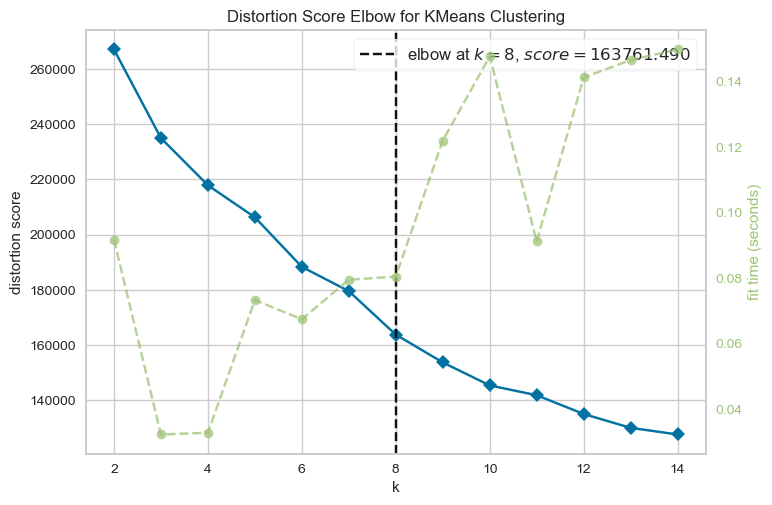

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the KMeans model
# random_state=42 is used for reproducibility of results
km = KMeans(random_state=42)

# Instantiate the KElbowVisualizer with the KMeans model
# k=(2,10) indicates the range of number of clusters to try (from 2 to 10)
visualizer = KElbowVisualizer(km, k=(2,15))

# Fit the visualizer to the data
# This will run K-means clustering for each value of k and calculate the distortion score for each
clustering = visualizer.fit(X_scale)

# Render the plot
# The Elbow plot displays the distortion score for each k
# The point where the distortion score starts to level off ('elbow') is the recommended number of clusters
visualizer.show()

El método del codo nos sugiere un valor de `k=8`. Veamos qué nos sugiere Silhouette.

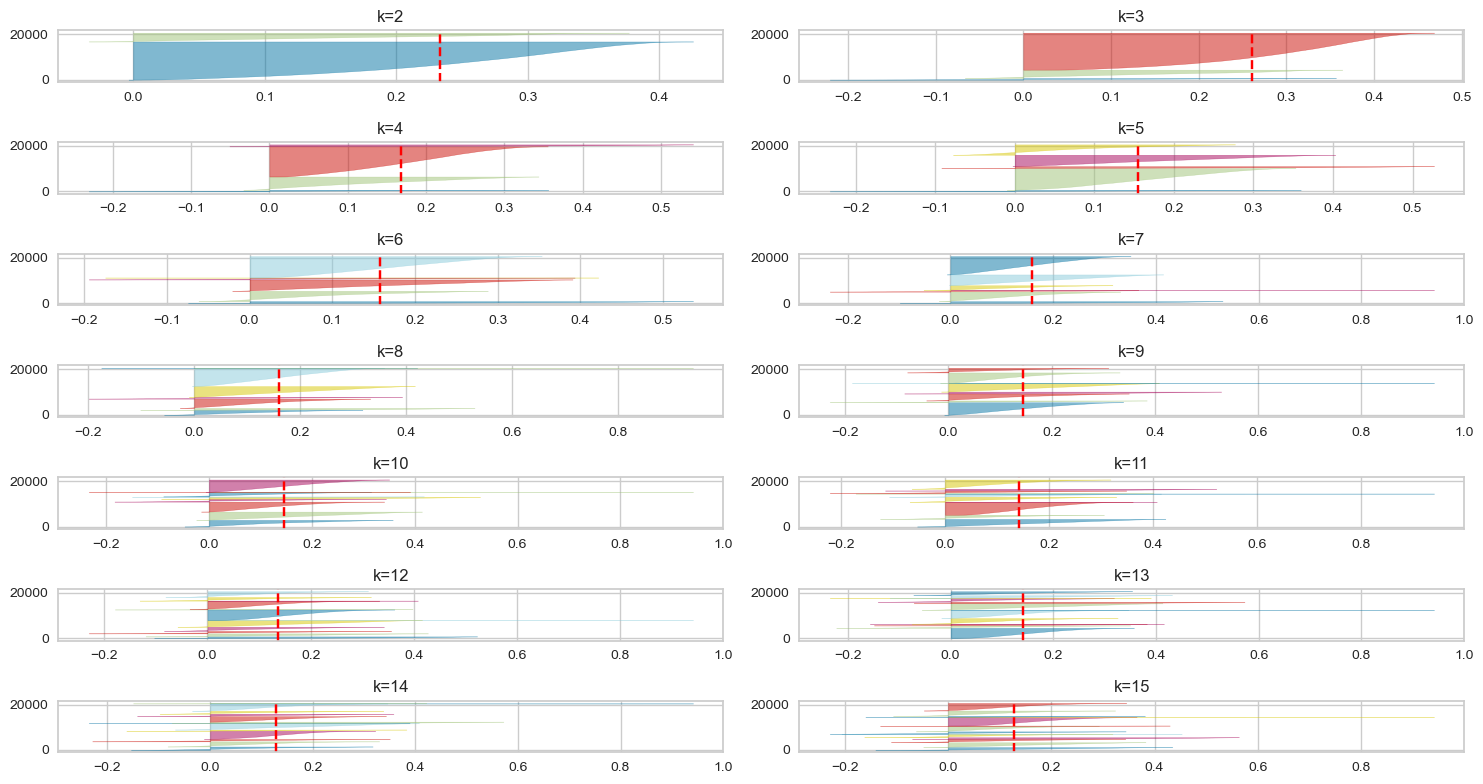

In [9]:
# A ver qué nos da Silhouette
from yellowbrick.cluster import SilhouetteVisualizer

# Setting up the matplotlib figure with multiple subplots
fig, ax = plt.subplots(7, 2, figsize=(15,8))

# Loop through different numbers of clusters (from 2 to 5)
for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11 , 12, 13, 14, 15]:
    # Create KMeans instance for different number of clusters
    # 'k-means++' for smart centroid initialization, 10 different centroid initializations
    # 100 iterations max for each run, and set a random state for reproducibility
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)

    # Determine the position of the subplot
    q, mod = divmod(i, 2)

    # Create a SilhouetteVisualizer with the KMeans instance
    # Colors are set to 'yellowbrick' palette, and the subplot ax is defined
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    ax[q-1][mod].set_title(f'k={i}')

    # Fit the visualizer to the data to produce the silhouette plot
    visualizer.fit(X_scale)

# Display the plot
plt.tight_layout()
plt.show()

Viendo que Elbow y Silhouette coinciden, elegiremos `k=8` como el número de clusters correctos.

## Asignación a Clusters

In [10]:
kmeans_8 = KMeans(n_clusters=8).fit(X_scale)

labels = kmeans_8.predict(X_scale)

clusters = kmeans_8.labels_.tolist()

In [11]:
df['labels_KMeans'] = clusters
df

,Artist,Track,Album,Album_type,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Channel,Views,Likes,Comments,Licensed,official_video,Stream,EnergyLiveness,most_playedon,labels_KMeans
0,Gorillaz,Feel Good Inc.,Demon Days,album,0.818,0.705,-6.679,0.1770,0.008360,0.002330,...,Gorillaz,693555221.0,6220896.0,169907.0,True,True,1.040235e+09,1.150082,Spotify,0
1,Gorillaz,Rhinestone Eyes,Plastic Beach,album,0.676,0.703,-5.815,0.0302,0.086900,0.000687,...,Gorillaz,72011645.0,1079128.0,31003.0,True,True,3.100837e+08,15.183585,Spotify,6
2,Gorillaz,New Gold (feat. Tame Impala and Bootie Brown),New Gold (feat. Tame Impala and Bootie Brown),single,0.695,0.923,-3.930,0.0522,0.042500,0.046900,...,Gorillaz,8435055.0,282142.0,7399.0,True,True,6.306347e+07,7.956897,Spotify,6
3,Gorillaz,On Melancholy Hill,Plastic Beach,album,0.689,0.739,-5.810,0.0260,0.000015,0.509000,...,Gorillaz,211754952.0,1788577.0,55229.0,True,True,4.346636e+08,11.546875,Spotify,6
4,Gorillaz,Clint Eastwood,Gorillaz,album,0.663,0.694,-8.627,0.1710,0.025300,0.000000,...,Gorillaz,618480958.0,6197318.0,155930.0,True,True,6.172597e+08,9.942693,Youtube,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20589,SICK LEGEND,JUST DANCE HARDSTYLE,JUST DANCE HARDSTYLE,single,0.582,0.926,-6.344,0.0328,0.448000,0.000000,...,SICK LEGEND - Topic,71678.0,1113.0,0.0,True,True,9.227144e+06,11.036949,Spotify,6
20590,SICK LEGEND,SET FIRE TO THE RAIN HARDSTYLE,SET FIRE TO THE RAIN HARDSTYLE,single,0.531,0.936,-1.786,0.1370,0.028000,0.000000,...,SICK LEGEND - Topic,164741.0,2019.0,0.0,True,True,1.089818e+07,10.140845,Spotify,6
20591,SICK LEGEND,OUTSIDE HARDSTYLE SPED UP,OUTSIDE HARDSTYLE SPED UP,single,0.443,0.830,-4.679,0.0647,0.024300,0.000000,...,SICK LEGEND - Topic,35646.0,329.0,0.0,True,True,6.226110e+06,5.389610,Spotify,2
20592,SICK LEGEND,ONLY GIRL HARDSTYLE,ONLY GIRL HARDSTYLE,single,0.417,0.767,-4.004,0.4190,0.356000,0.018400,...,SICK LEGEND - Topic,6533.0,88.0,0.0,True,True,6.873961e+06,7.101852,Spotify,7


In [12]:
print('Valores únicos de cluster:', df['labels_KMeans'].nunique())
df['labels_KMeans'].value_counts()

Valores únicos de cluster: 8


labels_KMeans
1    5913
2    4210
5    3412
6    2382
7    1909
3    1405
4     817
0     544
Name: count, dtype: int64

## Clustering de Datos con DBSCAN

In [13]:
from sklearn.cluster import DBSCAN 

# Applying DBSCAN
# eps: The maximum distance between two samples for them to be considered as in the same neighborhood
# min_samples: The number of samples in a neighborhood for a point to be considered as a core point
dbscan = DBSCAN(eps=3.1, min_samples=7)
clusters = dbscan.fit_predict(X_scale)

In [14]:
df['labels_DBSCAN'] = clusters
df

,Artist,Track,Album,Album_type,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Views,Likes,Comments,Licensed,official_video,Stream,EnergyLiveness,most_playedon,labels_KMeans,labels_DBSCAN
0,Gorillaz,Feel Good Inc.,Demon Days,album,0.818,0.705,-6.679,0.1770,0.008360,0.002330,...,693555221.0,6220896.0,169907.0,True,True,1.040235e+09,1.150082,Spotify,0,0
1,Gorillaz,Rhinestone Eyes,Plastic Beach,album,0.676,0.703,-5.815,0.0302,0.086900,0.000687,...,72011645.0,1079128.0,31003.0,True,True,3.100837e+08,15.183585,Spotify,6,0
2,Gorillaz,New Gold (feat. Tame Impala and Bootie Brown),New Gold (feat. Tame Impala and Bootie Brown),single,0.695,0.923,-3.930,0.0522,0.042500,0.046900,...,8435055.0,282142.0,7399.0,True,True,6.306347e+07,7.956897,Spotify,6,0
3,Gorillaz,On Melancholy Hill,Plastic Beach,album,0.689,0.739,-5.810,0.0260,0.000015,0.509000,...,211754952.0,1788577.0,55229.0,True,True,4.346636e+08,11.546875,Spotify,6,0
4,Gorillaz,Clint Eastwood,Gorillaz,album,0.663,0.694,-8.627,0.1710,0.025300,0.000000,...,618480958.0,6197318.0,155930.0,True,True,6.172597e+08,9.942693,Youtube,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20589,SICK LEGEND,JUST DANCE HARDSTYLE,JUST DANCE HARDSTYLE,single,0.582,0.926,-6.344,0.0328,0.448000,0.000000,...,71678.0,1113.0,0.0,True,True,9.227144e+06,11.036949,Spotify,6,0
20590,SICK LEGEND,SET FIRE TO THE RAIN HARDSTYLE,SET FIRE TO THE RAIN HARDSTYLE,single,0.531,0.936,-1.786,0.1370,0.028000,0.000000,...,164741.0,2019.0,0.0,True,True,1.089818e+07,10.140845,Spotify,6,0
20591,SICK LEGEND,OUTSIDE HARDSTYLE SPED UP,OUTSIDE HARDSTYLE SPED UP,single,0.443,0.830,-4.679,0.0647,0.024300,0.000000,...,35646.0,329.0,0.0,True,True,6.226110e+06,5.389610,Spotify,2,0
20592,SICK LEGEND,ONLY GIRL HARDSTYLE,ONLY GIRL HARDSTYLE,single,0.417,0.767,-4.004,0.4190,0.356000,0.018400,...,6533.0,88.0,0.0,True,True,6.873961e+06,7.101852,Spotify,7,0


In [15]:
print('Valores únicos de cluster:', df['labels_DBSCAN'].nunique())
df['labels_DBSCAN'].value_counts()

Valores únicos de cluster: 4


labels_DBSCAN
 0    20426
-1      149
 1        9
 2        8
Name: count, dtype: int64

Observar `-1`, que representa los valores atípicos detectados por DBSCAN !!! 

Esta etiqueta significa que no encajan bien en ningún cluster basándose en los valores de `eps` y `min_samples`.

## CONCLUSIONES:

No parece que DBSCAN nos sirva para el propósito que queremos ya que sólo es capaz de agrupar los datos en muy pocos clusters, probablemente porque las muetras están muy juntas.

Por tanto, en nuestro caso, funciona mejor K-Means. Por lo general, K-Means funciona bien con clusters bien definidos y sin mucho ruido (valores atípicos).

## Visualización de Clusters

In [16]:
print('Columnas numéricas para el modelado:')
for idx, c in enumerate(numericals):
    print(f'{idx}: {c}')

Columnas numéricas para el modelado:
0: Danceability
1: Energy
2: Loudness
3: Speechiness
4: Acousticness
5: Instrumentalness
6: Liveness
7: Valence
8: Tempo
9: Duration_min
10: Views
11: Likes
12: Comments
13: Stream
14: EnergyLiveness


In [17]:
import plotly.graph_objects as go  #for 3D plot

## K-means using k = 8
labels = kmeans_8.labels_

## 3D plot 
Scene = dict(xaxis = dict(title  = 'Danceability -->'),yaxis = dict(title  = 'Energy --->'),zaxis = dict(title  = 'Acousticness -->'))
trace = go.Scatter3d(x=X_scale[:, 0], y=X_scale[:, 1], z=X_scale[:, 4], mode='markers', marker=dict(color=labels, size=8, line=dict(color= 'black',width = 10)))

layout = go.Layout(margin=dict(l=0,r=0), scene=Scene, height=800, width=800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [18]:
print(X.shape)
print(len(labels))

(20592, 15)
20592


In [19]:
# Reducimos el número de muestras a 1000, elegidas aleatoriamente, para que los clústers se visualicen mejor.
indices4plot = pd.DataFrame(X_scale).sample(1000).index
indices4plot

Index([ 9810,  5016, 20441, 13767, 16518,   511, 13056,  1573, 20129,  1686,
       ...
       18724, 18350,  9622,  2004,   453,   778,  8602,  1352, 14493, 15718],
      dtype='int64', length=1000)

In [20]:
labels4plot = labels[indices4plot.to_list()]
len(labels4plot)

1000

In [21]:
numplots = 0
for c1, c2, c3 in itertools.combinations(numericals, 3):
    numplots = numplots + 1
print('Número de plots para todas las combinaciones de variables:', numplots)

Número de plots para todas las combinaciones de variables: 455


In [22]:
lstplots_global = []

In [34]:
# Genera gráficos para todas las combinaciones de columnas numéricas
print(lstplots_global)
print('Number of plots so far:', len(lstplots_global))
print()
lstplots = []
for c1, c2, c3 in itertools.combinations(numericals, 3):
    
    idxc1 = numericals.get_loc(c1)
    idxc2 = numericals.get_loc(c2)
    idxc3 = numericals.get_loc(c3)
    
    t = (idxc1,idxc2,idxc3)

    if t not in lstplots_global:
        print(f'{idxc1}:{c1}, {idxc2}:{c2}, {idxc3}:{c3}')

        Scene = dict(xaxis = dict(title  = f'{c1} -->'),yaxis = dict(title  = f'{c2} --->'),zaxis = dict(title  = f'{c3} -->'))
        trace = go.Scatter3d(x=X_scale[indices4plot, idxc1], y=X_scale[indices4plot, idxc2], z=X_scale[indices4plot, idxc3], mode='markers', marker=dict(color=labels4plot, size=5, line=dict(color= 'black',width = 10)))

        layout = go.Layout(margin=dict(l=0,r=0), scene=Scene, height=800, width=800)
        data = [trace]
        fig = go.Figure(data = data, layout = layout)
        fig.show()

        lstplots.append(t)

        if len(lstplots) == 10:
            break

lstplots_global.extend(lstplots)

# Gràfiques interessants:
# 0:Danceability, 1:Energy, 4:Acousticness
# 0:Danceability, 1:Energy, 7:Valence
# 0:Danceability, 1:Energy, 8:Tempo
# 0:Danceability, 3:Speechiness, 4:Acousticness
# 6:Liveness, 3:Speechiness, 4:Acousticness
# 0:Danceability, 3:Speechiness, 14:EnergyLiveness
# 1:Energy, 3:Speechiness, 4:Acousticness
# 1:Energy, 3:Speechiness, 6:Liveness
# 1:Energy, 3:Speechiness, 14:EnergyLiveness
# 1:Energy, 4:Acousticness, 7:Valence

[(0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 1, 9), (0, 1, 10), (0, 1, 11), (0, 1, 12), (0, 1, 13), (0, 1, 14), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 2, 7), (0, 2, 8), (0, 2, 9), (0, 2, 10), (0, 2, 11), (0, 2, 12), (0, 2, 13), (0, 2, 14), (0, 3, 4), (0, 3, 5), (0, 3, 6), (0, 3, 7), (0, 3, 8), (0, 3, 9), (0, 3, 10), (0, 3, 11), (0, 3, 12), (0, 3, 13), (0, 3, 14), (0, 4, 5), (0, 4, 6), (0, 4, 7), (0, 4, 8), (0, 4, 9), (0, 4, 10), (0, 4, 11), (0, 4, 12), (0, 4, 13), (0, 4, 14), (0, 5, 6), (0, 5, 7), (0, 5, 8), (0, 5, 9), (0, 5, 10), (0, 5, 11), (0, 5, 12), (0, 5, 13), (0, 5, 14), (0, 6, 7), (0, 6, 8), (0, 6, 9), (0, 6, 10), (0, 6, 11), (0, 6, 12), (0, 6, 13), (0, 6, 14), (0, 7, 8), (0, 7, 9), (0, 7, 10), (0, 7, 11), (0, 7, 12), (0, 7, 13), (0, 7, 14), (0, 8, 9), (0, 8, 10), (0, 8, 11), (0, 8, 12), (0, 8, 13), (0, 8, 14), (0, 9, 10), (0, 9, 11), (0, 9, 12), (0, 9, 13), (0, 9, 14), (0, 10, 11), (0, 10, 12), (0, 10, 13), (0, 10, 14), (0, 11, 12)

1:Energy, 3:Speechiness, 12:Comments


1:Energy, 3:Speechiness, 13:Stream


1:Energy, 3:Speechiness, 14:EnergyLiveness


1:Energy, 4:Acousticness, 5:Instrumentalness


1:Energy, 4:Acousticness, 6:Liveness


1:Energy, 4:Acousticness, 7:Valence


1:Energy, 4:Acousticness, 8:Tempo


1:Energy, 4:Acousticness, 9:Duration_min


1:Energy, 4:Acousticness, 10:Views


In [52]:
df_clusters = df[['Artist','Track','labels_KMeans']]
df_clusters.to_csv('./datasets/kaggle/clusters.csv', index=True)